In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))

from utils import (
    get_latest_experiments,
    aggregate_metrics,
    plot_all_metrics,
    plot_class_performances,
    plot_metric_comparison,
    permutation_test,
    plot_permutation_test_distribution,
    plot_permutation_anova_distribution,
    permutation_anova, 
    calculate_class_performance,
    plot_class_performance,
    plot_class_performance_comparison,
    plot_classes_maps,
    filter_experiment,
    load_json_file,
    METRIC_FILES
)

BASE_DIR = "../../local_experiments/retr_fsl_train_test_glomerulo"

In [2]:
# Specify a list of experiment folder names.
# Example usage:
#   - specific_experiments = []             -> process the latest experiment for each type.
#   - specific_experiments = ["exp1_folder"]  -> process only that experiment.
#   - specific_experiments = ["exp1_folder", "exp2_folder"] -> process multiple experiments.
specific_experiments = []  # Change as needed; empty list means "use latest per experiment type"

# Retrieve the experiments based on the provided filter.
latest_experiments = get_latest_experiments(BASE_DIR, specific_experiments)


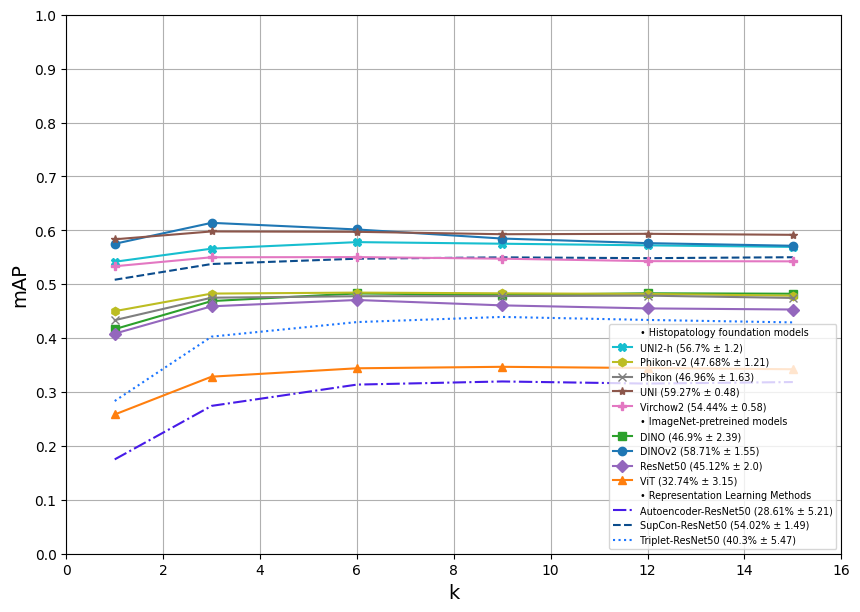

In [3]:
plot_metric_comparison(
        "mAP", 
        latest_experiments,
        legend_location='lower right',
        save_as="glomerulo_fsl_and_contrastive",
    )
# Aumentar a letra "K"
# Top 10
# Applicar normalização nos embeddings
# usar apenas datasewt Glomerlo, Ovarian cance e skin cancer 

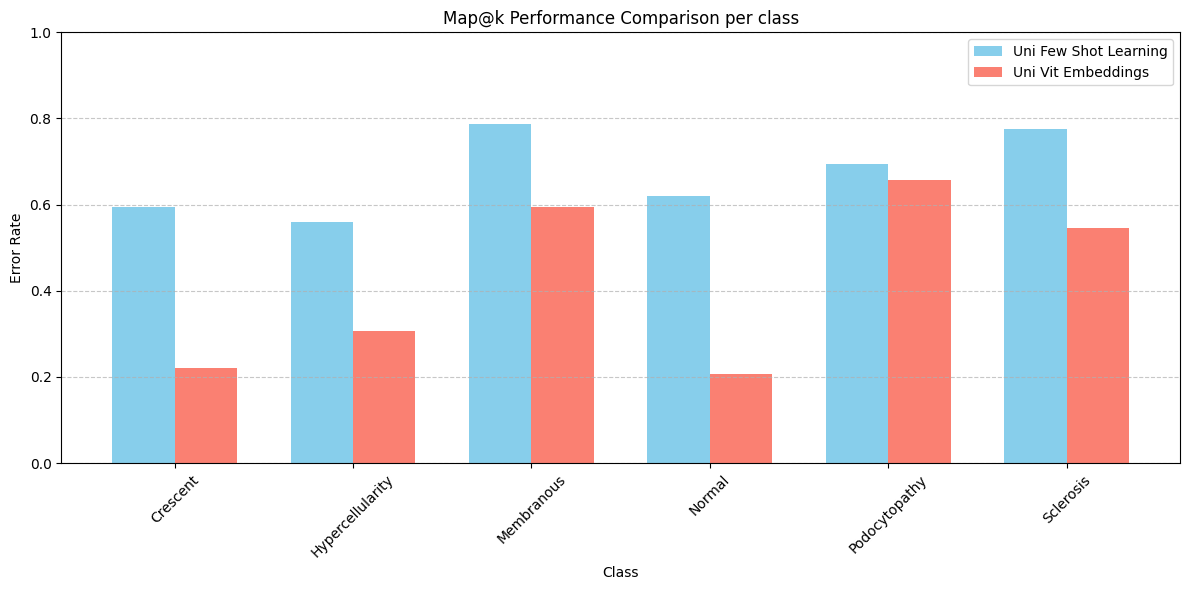

In [3]:
exp1 ='glomerulo-uni-backbone-map_at_k_query_details.json'
exp2 ='glomerulo-uni-fsl-map_at_k_query_details.json'
performance = calculate_class_performance(exp1)
# plot_class_performance(performance, 'map')

# performance = calculate_class_performance()
# plot_class_performance(performance, 'map')

plot_class_performance_comparison(exp1, exp2, label1="Uni Few Shot Learning", label2="Uni Vit Embeddings", title="Map@k Performance Comparison per class")

In [14]:
def load_results_for_boxplot(query_retrievals_file):
    """
    Calculate performance per class using the query retrievals file.
    
    Expected JSON format:
    {
      "mapk": <float>,
      "k": <int>,
      "query_retrievals": [
         {
           "average_precision": <float>,
           "query_label": <int>,
           "query_class": <str>,
           "query_path": <str>,
           "retrieved": [
             {
               "k": <int>,
               "retrieved_label": <int>,
               "retrieved_class": <str>,
               "retrieved_path": <str>,
               "is_relevant": <int>,   # 1 if relevant, 0 otherwise
               "similarity": <float>
             },
             ...
           ]
         },
         ...
      ]
    }
    
    For each query, a query is considered "correct" if at least one retrieved item has is_relevant==1.
    
    Returns a dictionary with statistics per query class.
    """
    data = load_json_file(query_retrievals_file)
    if data is None:
        return {}
    
    queries = data.get("query_retrievals", [])
    if not queries:
        print("No query retrievals found in the file.")
        return {}
    
    from collections import defaultdict
    class_stats = defaultdict(list)
    for query in queries:
        query_class = query.get("query_class")
        class_stats[query_class].append(query.get('average_precision'))
        
    return class_stats
import matplotlib.pyplot as plt
import numpy as np
  
def plot_classwise_boxplot_comparison(dict1, dict2, model1_name="Model 1", model2_name="Model 2", save_path=None):
    all_keys = sorted(set(dict1.keys()) | set(dict2.keys()))
    data = []
    labels = []
    positions = []
    
    width = 0.35  # espaçamento entre modelos
    spacing = 1.5  # espaçamento entre grupos

    base_pos = 0
    for key in all_keys:
        # coleta dados
        d1 = dict1.get(key, [])
        d2 = dict2.get(key, [])

        data.append(d1)
        data.append(d2)

        # posições do boxplot
        positions.append(base_pos)
        positions.append(base_pos + width)

        # label apenas no centro do grupo
        labels.append(f"{key}\n({model1_name})")
        labels.append(f"{key}\n({model2_name})")

        base_pos += spacing

    # configura estilo científico
    plt.style.use('ggplot') 
    plt.rcParams.update({
        'font.size': 12,
        'axes.labelsize': 13,
        'axes.titlesize': 14,
        'legend.fontsize': 11,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'pdf.fonttype': 42,
        'ps.fonttype': 42,
    })

    fig, ax = plt.subplots(figsize=(max(10, len(all_keys) * 1.2), 5))

    # boxplots
    box = ax.boxplot(data, positions=positions, widths=0.3, patch_artist=True, showfliers=False)

    colors = ['#1f77b4', '#ff7f0e'] * len(all_keys)
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_edgecolor('black')

    # eixo x
    n_keys = len(all_keys)
    xtick_positions = [i * spacing + width / 2 for i in range(n_keys)]
    ax.set_xticks(xtick_positions)
    ax.set_xticklabels(all_keys, rotation=45, ha='right')

    # eixo y
    ax.set_ylabel("Average Precision")
    ax.set_title("Class-wise Average Precision Comparison")

    # legenda
    handles = [
        plt.Line2D([0], [0], color='#1f77b4', lw=6),
        plt.Line2D([0], [0], color='#ff7f0e', lw=6)
    ]
    ax.legend(handles, [model1_name, model2_name], loc='upper left')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
    else:
        plt.show()

def plot_classwise_violin_comparison(dict1, dict2, model1_name="Model 1", model2_name="Model 2", save_path=None):
    all_keys = sorted(set(dict1.keys()) | set(dict2.keys()))
    data = []
    positions = []
    colors = []
    width = 0.3
    spacing = 1.2

    base_pos = 0
    for key in all_keys:
        d1 = dict1.get(key, [])
        d2 = dict2.get(key, [])

        data.append(d1)
        data.append(d2)

        positions.append(base_pos)
        positions.append(base_pos + width)

        colors.extend(['#1f77b4', '#ff7f0e'])  # azul e laranja

        base_pos += spacing

    # Preparar posições dos rótulos
    xtick_positions = [i * spacing + width / 2 for i in range(len(all_keys))]

    # Estilo científico
    plt.style.use('bmh')
    plt.rcParams.update({
        'font.size': 12,
        'axes.labelsize': 13,
        'axes.titlesize': 14,
        'legend.fontsize': 11,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'pdf.fonttype': 42,
        'ps.fonttype': 42,
    })

    fig, ax = plt.subplots(figsize=(max(10, len(all_keys) * 1.2), 5))

    # Gráfico de violino customizado
    parts = ax.violinplot(data, positions=positions, widths=width, showmeans=False, showextrema=False, showmedians=True)

    # Cores dos violinos
    for i, pc in enumerate(parts['bodies']):
        pc.set_facecolor(colors[i])
        pc.set_edgecolor('black')
        pc.set_alpha(0.7)

    # Linhas de mediana
    if 'cmedians' in parts:
        parts['cmedians'].set_color('black')
        parts['cmedians'].set_linewidth(1)

    # Eixo x
    ax.set_xticks(xtick_positions)
    ax.set_xticklabels(all_keys, rotation=45, ha='right')

    ax.set_ylabel("Average Precision")
    ax.set_title("Class-wise Average Precision (Violin Plot)")

    # Legenda
    handles = [
        plt.Line2D([0], [0], color='#1f77b4', lw=6),
        plt.Line2D([0], [0], color='#ff7f0e', lw=6)
    ]
    ax.legend(handles, [model1_name, model2_name], loc='upper left')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
    else:
        plt.show()
        
        
r = load_results_for_boxplot(exp1)


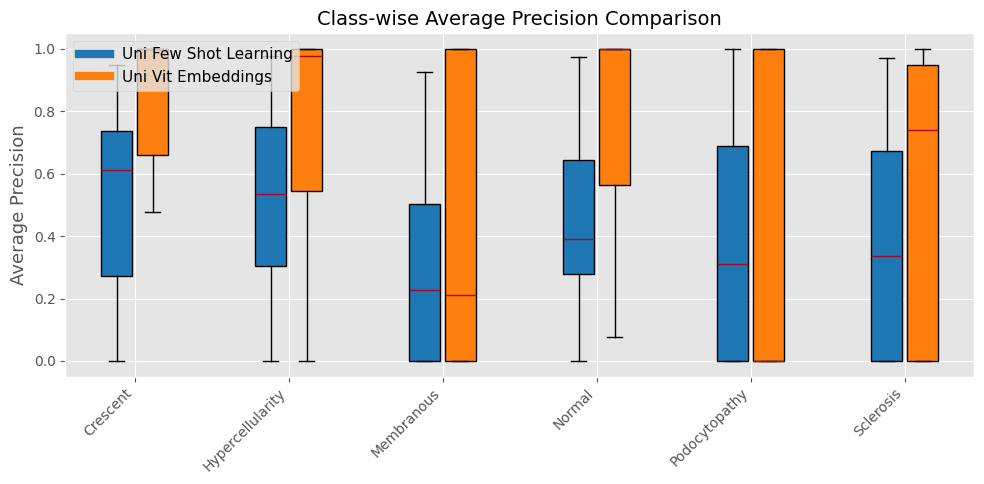

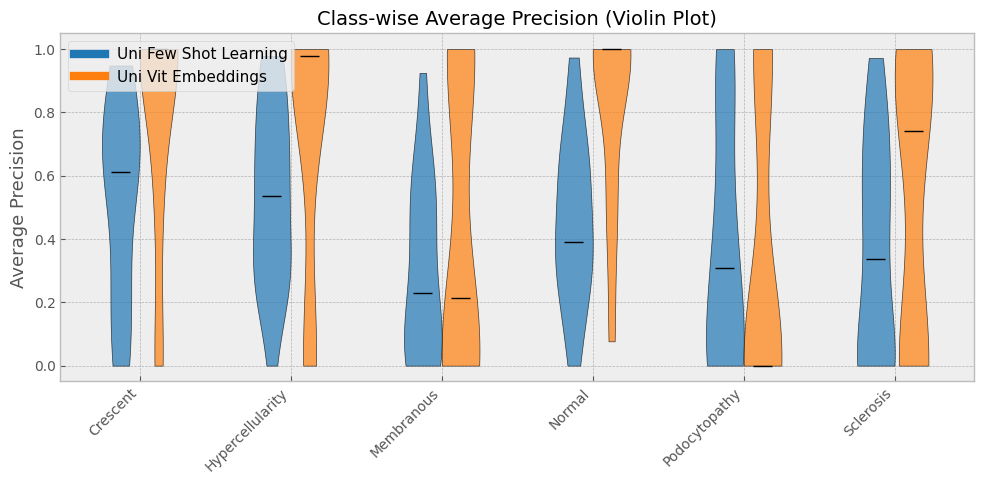

In [15]:
plot_classwise_boxplot_comparison(
    r, 
    load_results_for_boxplot(exp2), 
    model1_name="Uni Few Shot Learning", 
    model2_name="Uni Vit Embeddings",
    save_path="classwise_comparison.pdf"
)
plot_classwise_violin_comparison(
    r, 
    load_results_for_boxplot(exp2), 
    model1_name="Uni Few Shot Learning", 
    model2_name="Uni Vit Embeddings",
    save_path="classwise_comparison.pdf"
)

In [5]:
# plot_class_performances(latest_experiments)

Plotting class map for UNI2-h_fsl_glomerulo with k=15...


/home/matheus/dev/master-research-image-retrieval/notebooks/utils.py:410: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(classes, rotation=45, ha='right')


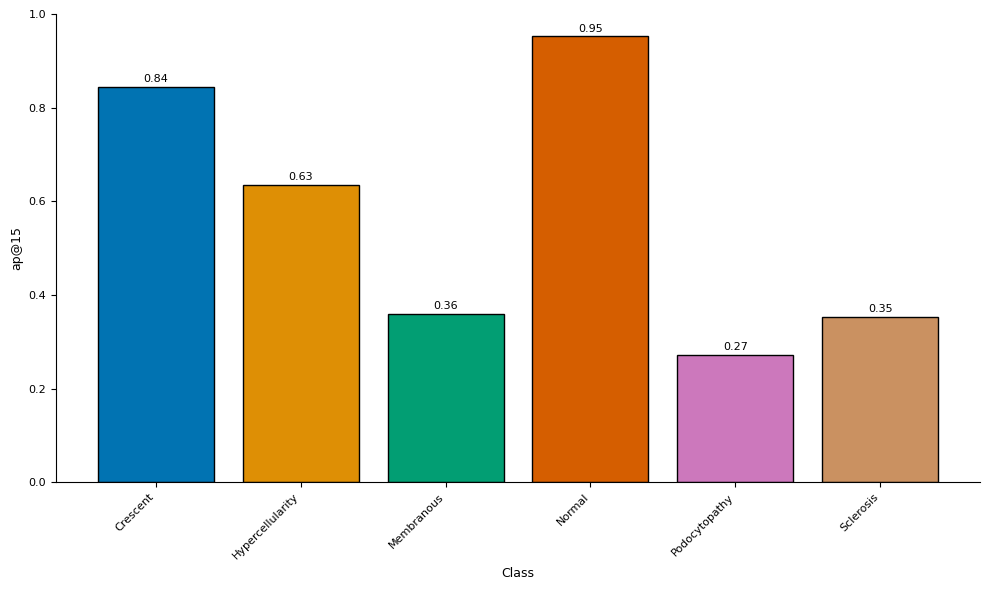

In [ ]:
exp = filter_experiment(latest_experiments, 'UNI2-h_fsl_glomerulo')
plot_classes_maps(
    exp,
    dataset='glomerulo', 
    save_fig=True
    )


In [4]:
# plot_classes_maps(
#     latest_experiments,
#     dataset=None, 
#     save_fig=False
#     )

In [3]:

# Load map_at_k_query_details.json for each model in latest_experiments
models = {}
for model_name, model_info in latest_experiments.items():
    details_file = f"{model_info['path']}/{METRIC_FILES['map']['details']}"
    try:
        with open(details_file, "r") as f:
            models[model_name] = json.load(f)
    except:
        pass
# Dynamically assign models to variables for hypothesis testing
locals().update({f"model{i+1}": models[model_name] for i, model_name in enumerate(models.keys())})


In [3]:
pretreined_model = load_json_file('glomerulo-uni-backbone-map_at_k_query_details.json')
finetuned_model = load_json_file('glomerulo-uni-fsl-map_at_k_query_details.json')

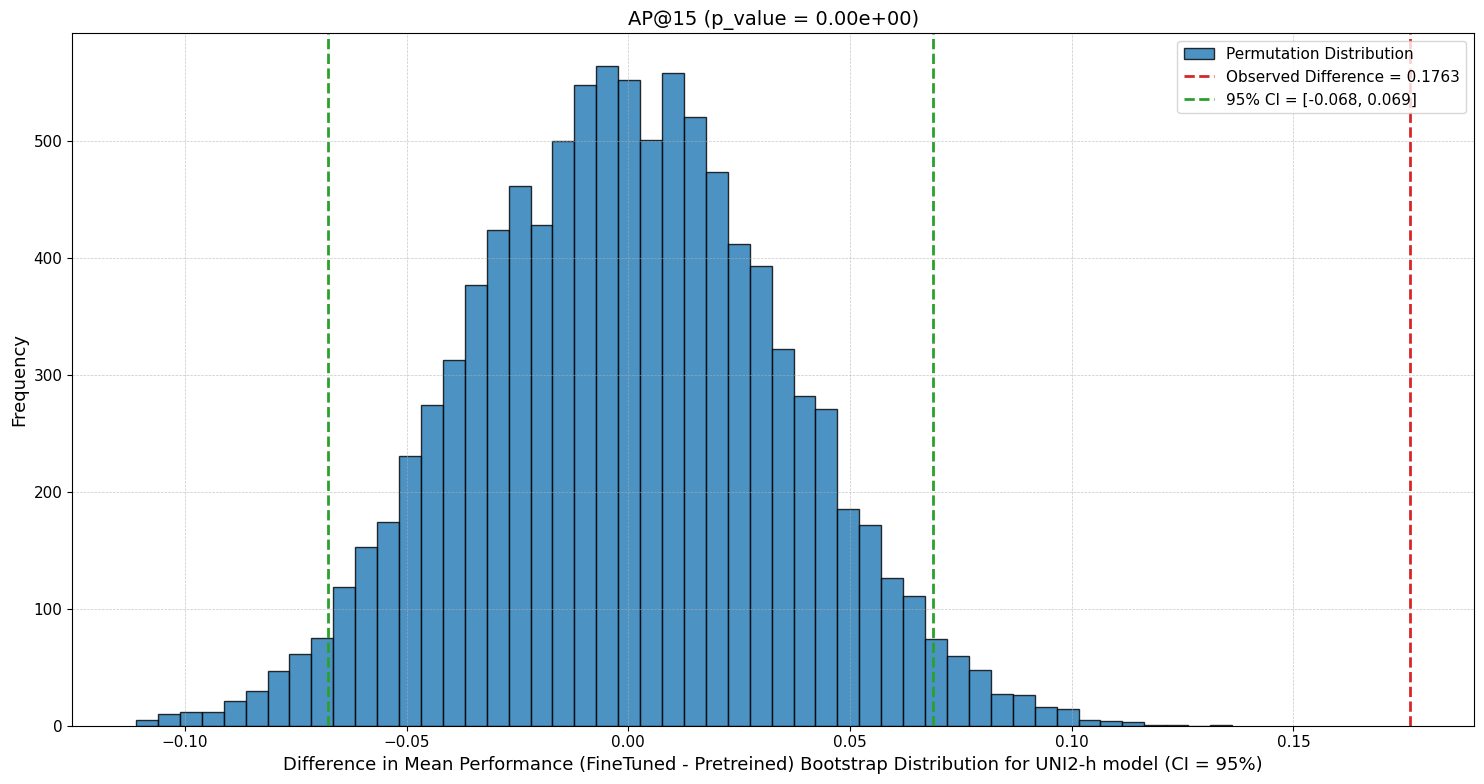

In [6]:
result = permutation_test(finetuned_model, pretreined_model, 95)
plot_permutation_test_distribution(result)

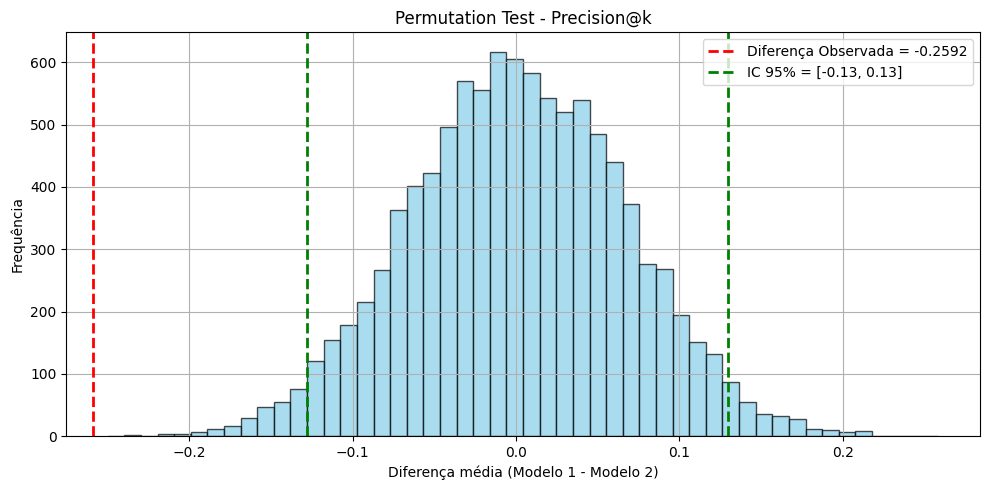

In [ ]:
result = permutation_test(model1, model3, 95)
plot_permutation_test_distribution(result)

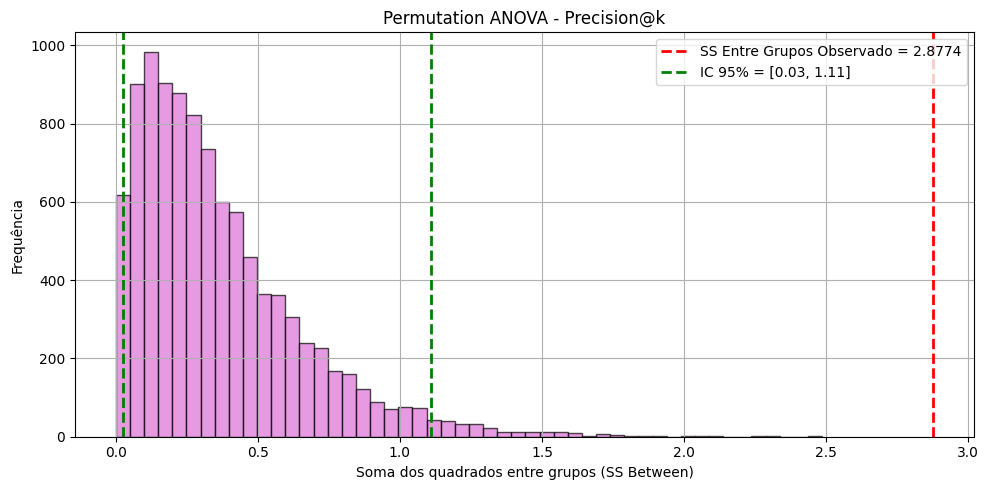

In [ ]:
res = permutation_anova([model1, model2, model3, model4], n_permutations=10000, seed=42, confidence=95)
plot_permutation_anova_distribution(res)